Episode 100/1200, Reward: 36.50, Epsilon: 0.294
Episode 200/1200, Reward: 47.50, Epsilon: 0.155
Episode 300/1200, Reward: 46.20, Epsilon: 0.088
Episode 400/1200, Reward: 40.80, Epsilon: 0.052
Episode 500/1200, Reward: 44.50, Epsilon: 0.050
Episode 600/1200, Reward: 45.10, Epsilon: 0.050
Episode 700/1200, Reward: 43.90, Epsilon: 0.050
Episode 800/1200, Reward: 45.10, Epsilon: 0.050
Episode 900/1200, Reward: 45.10, Epsilon: 0.050
Episode 1000/1200, Reward: 46.90, Epsilon: 0.050
Episode 1100/1200, Reward: 46.30, Epsilon: 0.050
Episode 1200/1200, Reward: 43.90, Epsilon: 0.050


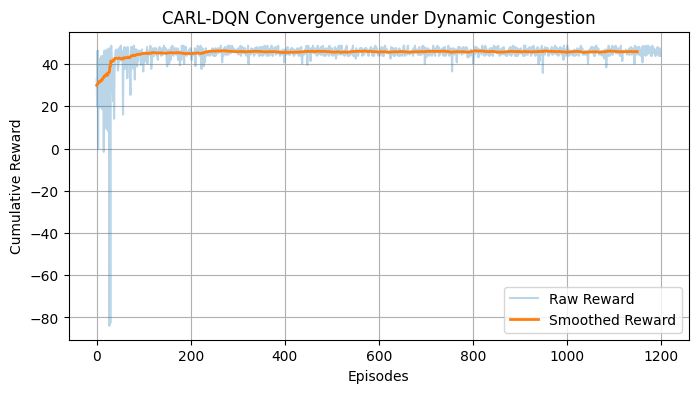

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


class DynamicRoutingEnv:
    def __init__(self, num_nodes=6, max_steps=15):
        self.num_nodes = num_nodes
        self.max_steps = max_steps


        self.base_delay = np.random.randint(1, 10, (num_nodes, num_nodes))
        self.congestion = np.random.rand(num_nodes, num_nodes)

        np.fill_diagonal(self.base_delay, 0)
        np.fill_diagonal(self.congestion, 0)

    def reset(self):
        self.current = np.random.randint(self.num_nodes)
        self.destination = np.random.randint(self.num_nodes)
        while self.destination == self.current:
            self.destination = np.random.randint(self.num_nodes)

        self.steps = 0
        return self._get_state()

    def _get_state(self):
        cur = np.zeros(self.num_nodes)
        dst = np.zeros(self.num_nodes)
        cur[self.current] = 1
        dst[self.destination] = 1


        state = np.concatenate([
            cur,
            dst,
            self.base_delay[self.current] / 10.0,
            self.congestion[self.current]
        ])

        return state.astype(np.float32)

    def valid_actions(self):
        return [i for i in range(self.num_nodes) if i != self.current]

    def step(self, action):
        self.steps += 1

        delay = self.base_delay[self.current][action]
        congestion = self.congestion[self.current][action]


        self.congestion += np.random.uniform(0.0, 0.05, self.congestion.shape)
        self.congestion = np.clip(self.congestion, 0, 1)

        reward = -0.6 * delay - 0.5 * congestion - 0.2
        self.current = action
        done = False

        if self.current == self.destination:
            reward += 50
            done = True

        if self.steps >= self.max_steps:
            reward -= 20
            done = True

        return self._get_state(), reward, done


class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


class CARLDQNAgent:
    def __init__(self, state_dim, action_dim):
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.tau = 0.01

        self.memory = deque(maxlen=10000)

        self.policy_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)

        state = torch.tensor(state).unsqueeze(0)
        q_values = self.policy_net(state).detach().numpy()[0]


        masked_q = np.full_like(q_values, -1e9)
        masked_q[valid_actions] = q_values[valid_actions]

        return np.argmax(masked_q)

    def store(self, s, a, r, s_, d):
        self.memory.append((s, a, r, s_, d))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        actions = torch.tensor(actions).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.policy_net(states).gather(1, actions).squeeze()
        next_q = self.target_net(next_states).max(1)[0]
        target = rewards + self.gamma * next_q * (1 - dones)

        loss = self.loss_fn(q_values, target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft target update
        for t, p in zip(self.target_net.parameters(), self.policy_net.parameters()):
            t.data.copy_(self.tau * p.data + (1 - self.tau) * t.data)

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


env = DynamicRoutingEnv()
state_dim = 4 * env.num_nodes
agent = CARLDQNAgent(state_dim, env.num_nodes)

episodes = 1200
reward_history = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0

    while True:
        action = agent.select_action(state, env.valid_actions())
        next_state, reward, done = env.step(action)

        agent.store(state, action, reward, next_state, done)
        agent.train()

        state = next_state
        total_reward += reward

        if done:
            break

    reward_history.append(total_reward)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")


def moving_average(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(8, 4))
plt.plot(reward_history, alpha=0.3, label="Raw Reward")
plt.plot(moving_average(reward_history), linewidth=2, label="Smoothed Reward")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.title("CARL-DQN Convergence under Dynamic Congestion")
plt.legend()
plt.grid()
plt.show()
